### Imports

In [1]:
# Imports and set up
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from torcheeg.io.eeg_signal import EEGSignalIO
from sklearn.model_selection import train_test_split
from einops import rearrange

## CKA stuff
import os
from cka import CKACalculator


## Path to dir with data (remember the last '/')
path = "../data/"

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(path), io_mode='lmdb')
## Read metadata dataframeimports
metadata = pd.read_csv(path + 'sample_metadata.tsv', sep='\t')

/home/albino/Documents/ITU/bachelor/src/cka.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Load data

In [2]:
# Verifying connextion to data
idxs = np.arange(len(metadata))

X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
print(f"nsamples: {X.shape[0]}  -  nchannels: {X.shape[1]}  -  t: {X.shape[2]}")

y = torch.tensor(metadata["value"].values, dtype=torch.long)

nsamples: 5184  -  nchannels: 22  -  t: 800


### Split data into train, validation and test sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"shape of X train: {X_train.shape}")
print(f"shape of X val: {X_val.shape}")
print(f"shape of X test: {X_test.shape}")

print(f"shape of y train: {y_train.shape}")
print(f"shape of y val: {y_val.shape}")
print(f"shape of y test: {y_test.shape}")

shape of X train: torch.Size([3110, 22, 800])
shape of X val: torch.Size([1037, 22, 800])
shape of X test: torch.Size([1037, 22, 800])
shape of y train: torch.Size([3110])
shape of y val: torch.Size([1037])
shape of y test: torch.Size([1037])


In [4]:
#set up of matrixies 
#number of samples, channels, and timesteps
nsamples_train, nchannels_train, t = X_train.shape
nsamples_val, nchannels_val, t = X_val.shape

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

adj_matrix_train = torch.eye(nchannels_train)
adj_matrix_val = torch.eye(nchannels_val)

In [5]:
print(adj_matrix_train.shape)
print(type(adj_matrix_train))
print(nsamples_train)

print(adj_matrix_val.shape)
print(type(adj_matrix_val))
print(nsamples_val)

torch.Size([22, 22])
<class 'torch.Tensor'>
3110
torch.Size([22, 22])
<class 'torch.Tensor'>
1037


### Model training definition

In [6]:
class TrainNN():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_loader, val_loader, learning_rate, epochs=100, prints=True,modrun=0):
        model = model.to(self.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        highest_train_accuracy = 0.0
        
        losses_train = []; losses_val = []

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0; running_loss_val = 0.0
            correct = 0; correct_val = 0
            total = 0; total_val = 0
            
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct/total
            losses_train.append(epoch_loss)
            
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss_val += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
            epoch_loss_val = running_loss_val / len(val_loader.dataset)
            epoch_accuracy_val = correct_val/total_val
            losses_val.append(epoch_loss_val)
                
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy

            if prints:
                print(f"Epoch {epoch+1}/{epochs}, Train loss: {epoch_loss:.4f}, Train acc: {(epoch_accuracy*100):.2f}%" +
                     f"| Val loss: {epoch_loss_val:.4f}, Val acc: {(epoch_accuracy_val*100):.2f}%")

        print(f"Highest Train Accuracy {(highest_train_accuracy*100):.2f}")
        torch.save(model.state_dict(), f'eeg_nnmod{modrun}.pth')

        
        losses = [losses_train, losses_val]

        return model, losses

### Model architecture

In [7]:
class CollapsedShallowNet(nn.Module):
    """
    A version of the ShallowFBCSPNet model with a combined spatiotemporal convolution instead of separate temporal and spatial convolutions

    Args:
        n_chans (int): Number of input channels.
        n_outputs (int): Number of output classes.
        n_times (int, optional): Number of timepoints in the input.
        dropout (float, optional): Dropout probability. Defaults to 0.5.
        num_kernels (int, optional): Number of kernels in the spatiotemporal convolution. Defaults to 40.
        kernel_size (int, optional): Size of the kernel in the spatiotemporal convolution. Defaults to 25.
        pool_size (int, optional): Size of the pooling window in the spatiotemporal convolution. Default is 100.
    """

    def __init__(self, n_chans, n_outputs, n_times=1001, dropout=0.5, num_kernels=40, kernel_size=25, pool_size=100):
        super(CollapsedShallowNet, self).__init__()
        self.spatio_temporal = nn.Conv2d(
            n_chans, num_kernels, (1, kernel_size))
        self.pool = nn.AvgPool2d((1, pool_size))
        self.batch_norm = nn.BatchNorm2d(num_kernels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.LazyLinear(n_outputs)

    def forward(self, x):
        x = torch.unsqueeze(x, dim=2)
        x = self.spatio_temporal(x)
        x = F.elu(x)
        x = self.batch_norm(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


### Training & model hyperparameters

In [8]:
# Model parameters
n_chans = 22
n_outputs = y.max().item() + 1
n_times = 800
dropout = 0.6
n_kernels = 40
kernel_size = 25
pool_size = 100

# Training parameters
lr = 1e-3
epochs = 20

#Models 
modruns = 4

### Training

In [9]:
mods=[]
def train_models(models=1,new =False):
    for i in range(models):
        tmp_mod=CollapsedShallowNet(n_chans, n_outputs, n_times=n_times, dropout=dropout, num_kernels=n_kernels,
                           kernel_size=kernel_size, pool_size=pool_size)
        pth=f"eeg_nnmod{i}.pth"
        if new or not os.path.exists(pth):    
            trainer = TrainNN()
            mods.append(trainer.train_model(tmp_mod, train_loader, val_loader, learning_rate=lr, epochs=epochs, prints=False, modrun=i))
        else: 
            tmp_mod.load_state_dict(torch.load(f"eeg_nnmod{i}.pth"))
            tmp_mod.eval()
            mods.append([tmp_mod,[]])

#model1 = CollapsedShallowNet(n_chans, n_outputs, n_times=n_times, dropout=dropout, num_kernels=n_kernels,kernel_size=kernel_size, pool_size=pool_size)

train_models(modruns)


/tmp/ipykernel_84749/3957929686.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tmp_mod.load_state_dict(torch.load(f"eeg_nnmod{i}.pth"))


No hook function provided. Using flatten_hook_fn.
5 Hooks registered. Total hooks: 5
No hook function provided. Using flatten_hook_fn.
5 Hooks registered. Total hooks: 5


Epoch 0:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

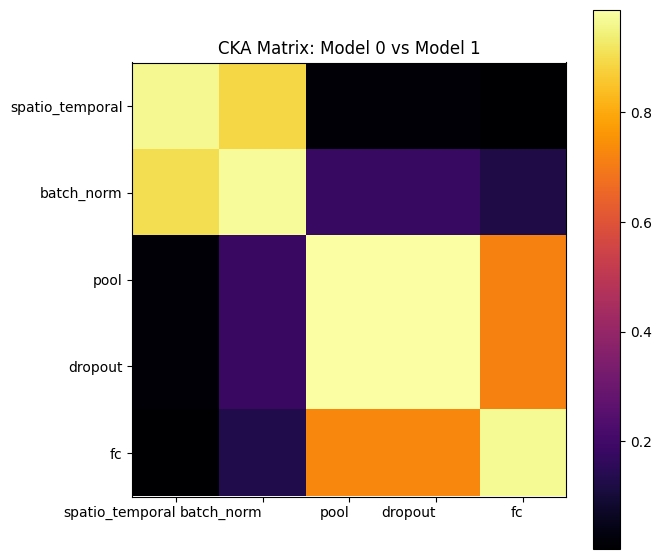

No hook function provided. Using flatten_hook_fn.
4 Hooks registered. Total hooks: 4
No hook function provided. Using flatten_hook_fn.
5 Hooks registered. Total hooks: 5


Epoch 0:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

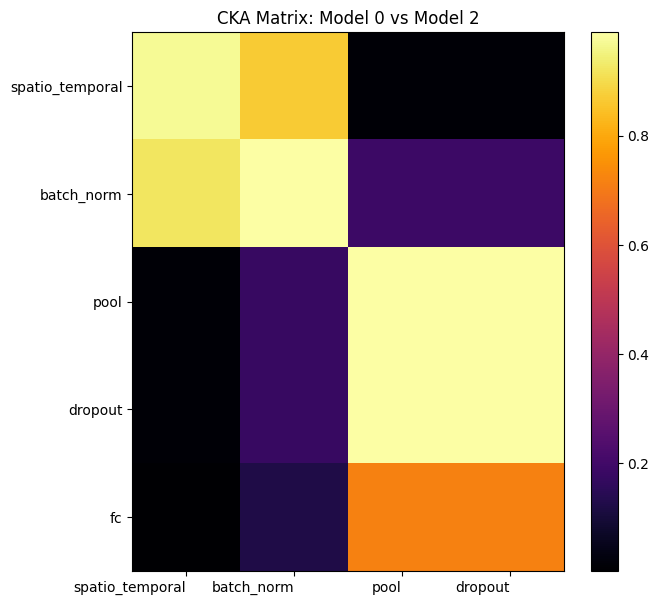

No hook function provided. Using flatten_hook_fn.
4 Hooks registered. Total hooks: 4
No hook function provided. Using flatten_hook_fn.
5 Hooks registered. Total hooks: 5


Epoch 0:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

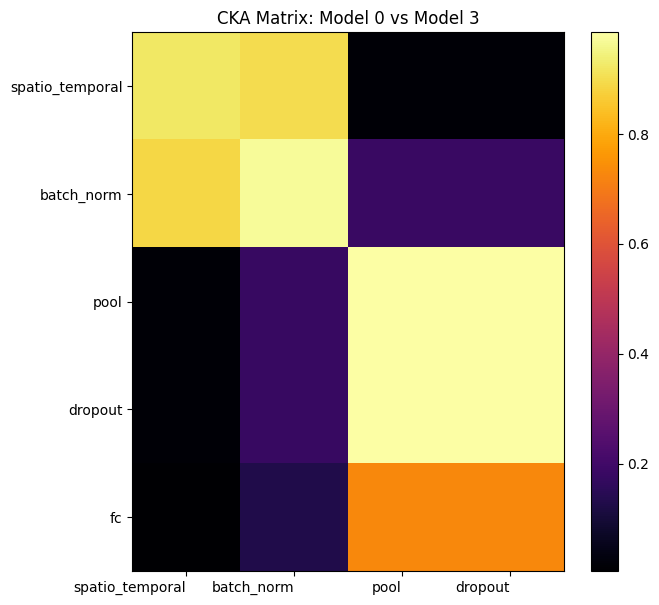

In [10]:
for i in range(modruns - 1):
    calculator = CKACalculator(model1=mods[0][0], model2=mods[i + 1][0], dataloader=train_loader)
    cka_output = calculator.calculate_cka_matrix()

    # Plot the matrix
    plt.figure(figsize=(7, 7))
    plt.imshow(cka_output.cpu().numpy(), cmap='inferno')
    plt.xticks(ticks=np.arange(len(calculator.module_names_X)), labels=calculator.module_names_X, ha="right")
    plt.yticks(ticks=np.arange(len(calculator.module_names_Y)), labels=calculator.module_names_Y)
    plt.colorbar()
    plt.title(f'CKA Matrix: Model 0 vs Model {i+1}')
    plt.show()  


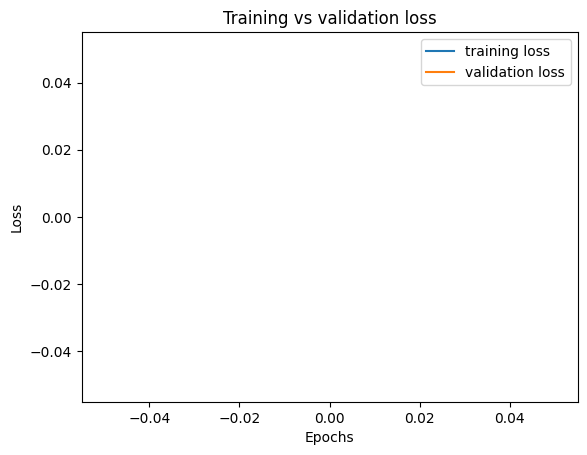

In [12]:
plt.plot(mods[0][1])
plt.plot(mods[1][1])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training loss","validation loss"])
plt.title("Training vs validation loss");